In [3]:
import os
import sys
import glob
import json
import tqdm

import numpy as np
import pandas as pd
import nibabel as nib

sys.path.append(os.path.join("..", "..", ".."))
from tta_uia_segmentation.src.preprocessing.utils import get_ADAM_filepaths_raw

# 01 - General Description and some statistics of the Dataset

## 1.0 Generate csv file with basic information per image
 - voxel size
 - field of view
 - volume of aneurysm class

In [4]:
tof_data_dir = '../../../../data/raw/ADAM/'
scans_dp_dict = get_ADAM_filepaths_raw(tof_data_dir)
len(scans_dp_dict)

In [8]:
aneurysm_label = 1
basic_desc = []
for image_name, fp_info in tqdm.tqdm(scans_dp_dict.items()):
    
    img_fp = fp_info['tof']
    label_fp = fp_info['seg']
    
    #print('processing image: ', image_name,  end='\r')
    
    # load nift image
    img = nib.load(img_fp)
    aneurysm_mask = nib.load(label_fp)
    
    # Get voxel_size_in each dimension
    y_size, x_size, z_size = img.header.get_zooms()
    
    # Get field of view in each dimension
    y_fov = y_size * img.shape[0]
    x_fov = x_size * img.shape[1]
    z_fov = z_size * img.shape[2]
    
    # Volume of the aneurysm
    aneurysm_volume = np.sum(aneurysm_mask.get_fdata() == aneurysm_label) * y_size * x_size * z_size
    
    # Total volume of the image
    total_volume = y_fov * x_fov * z_fov
    
    basic_desc.append(
        {
            'img_name': image_name,
            'y_size': y_size,
            'x_size': x_size,
            'z_size': z_size,
            'y_fov': y_fov,
            'x_fov': x_fov,
            'z_fov': z_fov,
            'aneurysm_volume': aneurysm_volume,
            'total_fov': total_volume,
        }
    )

100%|██████████| 113/113 [00:21<00:00,  5.18it/s]


In [9]:
basic_desc_df = pd.DataFrame(basic_desc).set_index('img_name').sort_index()
basic_desc_df.to_csv('basic_info_ADAM.csv')
basic_desc_df

,y_size,x_size,z_size,y_fov,x_fov,z_fov,aneurysm_volume,total_fov
img_name,,,,,,,,
10001,0.357143,0.357143,0.499999,200.000005,200.000005,69.999917,0.000000,2.799997e+06
10002,0.357143,0.357143,0.500000,200.000005,200.000005,69.999946,0.000000,2.799998e+06
10003,0.357143,0.357143,0.499999,200.000005,200.000005,69.999892,0.000000,2.799996e+06
10004,0.357143,0.357143,0.500000,200.000005,200.000005,70.000033,0.000000,2.800001e+06
10005,0.357143,0.357143,0.500000,200.000005,200.000005,69.999937,0.000000,2.799998e+06
...,...,...,...,...,...,...,...,...
10076F,0.195312,0.195312,0.499996,200.000000,200.000000,79.999328,38.547192,3.199973e+06
10077B,0.390625,0.390625,0.499999,200.000000,200.000000,69.999841,4.501333,2.799994e+06
10077F,0.357143,0.357143,0.550002,200.000005,200.000005,77.000302,3.788280,3.080012e+06


In [10]:
basic_desc_df = pd.read_csv('basic_info_ADAM.csv', index_col='img_name')

### What is the distribution of resolutions of the scans


In [11]:
basic_desc_df[['y_size', 'x_size', 'z_size']].describe()

,y_size,x_size,z_size
count,113.000000,113.000000,113.000000
mean,0.352362,0.352362,0.544688
std,0.056936,0.056936,0.092424
min,0.195312,0.195312,0.400000
25%,0.312500,0.312500,0.499999
50%,0.357143,0.357143,0.500000
75%,0.390625,0.390625,0.550000
max,0.585938,0.585938,1.000000


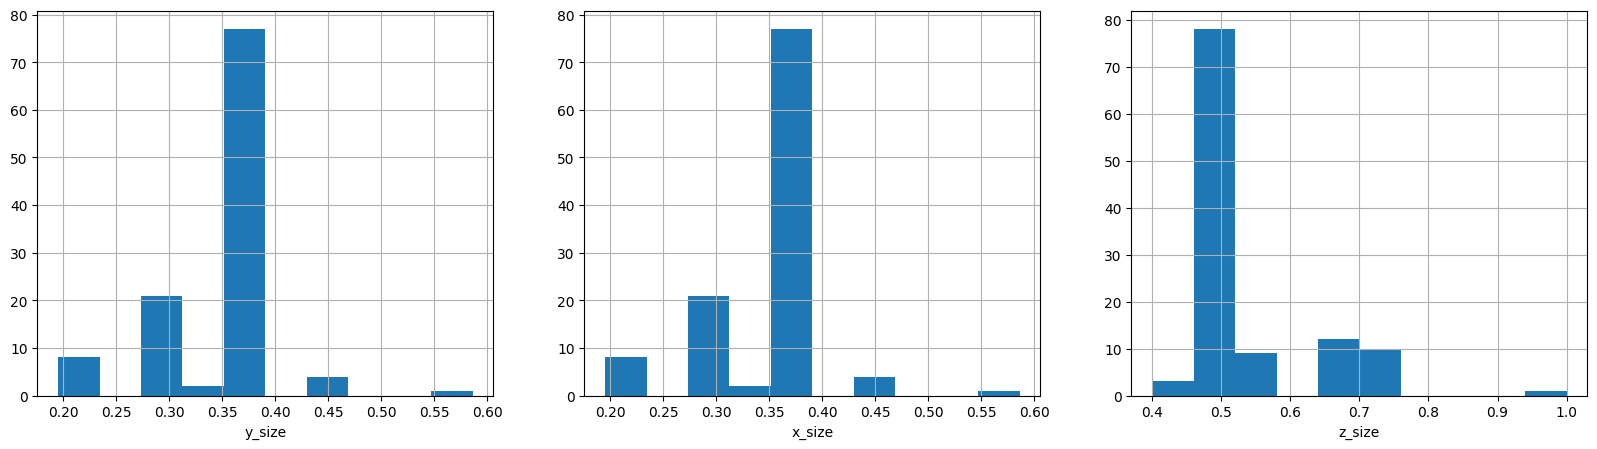

In [13]:
# Plot the histogram of y_size, x_size, z_size in 3 subfigures
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
basic_desc_df['y_size'].hist(ax=axes[0])
basic_desc_df['x_size'].hist(ax=axes[1])
basic_desc_df['z_size'].hist(ax=axes[2])
axes[0].set_xlabel('y_size')
axes[1].set_xlabel('x_size')
axes[2].set_xlabel('z_size')
plt.savefig('ADAM_dataset_size_histogram.png')

In [18]:
basic_desc_df.z_size.sort_values(ascending=False).head(10)

img_name
10078B    1.000000
10054B    0.700103
10075B    0.700063
10058B    0.700056
10018     0.700034
10030     0.700030
10068B    0.700021
10016     0.700015
10044B    0.700014
10012     0.700000
Name: z_size, dtype: float64

In [20]:
basic_desc_df.y_size.sort_values(ascending=False).head(10)

img_name
10071B    0.585938
10056B    0.429688
10065F    0.429688
10059B    0.429688
10037     0.429688
10050F    0.390625
10061F    0.390625
10032     0.390625
10060F    0.390625
10035     0.390625
Name: y_size, dtype: float64

In [21]:
basic_desc_df.x_size.sort_values(ascending=False).head(10)

img_name
10071B    0.585938
10056B    0.429688
10065F    0.429688
10059B    0.429688
10037     0.429688
10050F    0.390625
10061F    0.390625
10032     0.390625
10060F    0.390625
10035     0.390625
Name: x_size, dtype: float64

In [22]:
basic_desc_df.loc[['10078B', '10054B', '10071B', '10056B']]

,y_size,x_size,z_size,y_fov,x_fov,z_fov,aneurysm_volume,total_fov
img_name,,,,,,,,
10078B,0.312500,0.312500,1.000000,160.000000,160.000000,63.999985,126.855439,1.638400e+06
10054B,0.312500,0.312500,0.700103,160.000000,160.000000,70.010298,33.227544,1.792264e+06
10071B,0.585938,0.585938,0.499925,150.000122,150.000122,49.992532,97.660893,1.124834e+06
10056B,0.429688,0.429688,0.400019,110.000130,110.000130,40.001935,2.215689,4.840246e+05


In [25]:
np.sort(['10078B', '10054B', '10071B', '10056B'])

array(['10054B', '10056B', '10071B', '10078B'], dtype='<U6')

## 1.1 Distribution of UIAs location (per Vessel Type)

In [73]:
img.header.get_data_shape()

(652, 768, 168)

In [75]:
img.header["dim"][1:4]

array([652, 768, 168], dtype=int16)

## 1.2 Distribution of UIAs location (per Vessel Type and territory)

## 1.3 Distribution of UIAs per size

### Per maximum diameter 

For example in ranges [0, 5mm), [5mm, 10mm), [10mm, inf)

### Per volume

<Axes: >

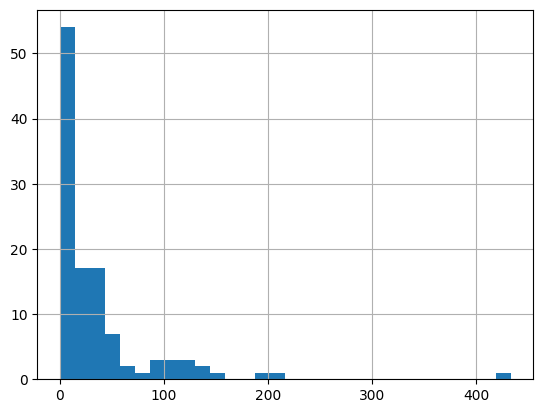

In [14]:
basic_desc_df.aneurysm_volume.hist(bins=30)

<Axes: >

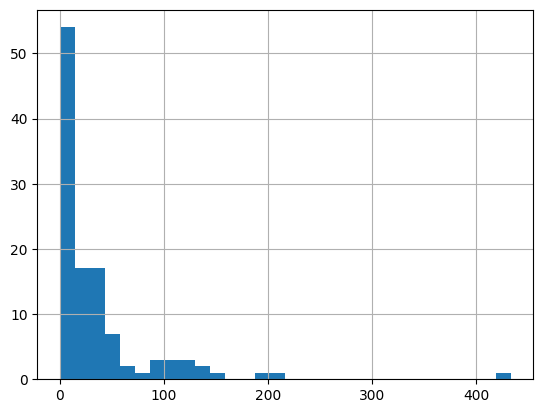

In [15]:
basic_desc_df.aneurysm_volume[basic_desc_df.aneurysm_volume < 1000].hist(bins=30)

In [17]:
basic_desc_df.aneurysm_volume.sort_values(ascending=False).head(10)

img_name
10059B    433.226897
10071F    203.763129
10065F    193.979644
10050B    155.442413
10050F    141.220059
10073B    133.663151
10052B    127.258119
10078B    126.855439
10073F    118.256179
10078F    105.740381
Name: aneurysm_volume, dtype: float64

### Per maximum median radius

## 1.4 Distribution of UIAs type (saccular or fusiform)